# Data Science Project 1: Marketing Experimentation

### 1. Background
An e-commerce company tested two versions of the shopping cart UI on their mobile app in order to increase the conversion rate.

The project is to analyze the A/B test results and decide whether to change the UI.

### 2. Data
The data we have is from 450k users devided in to control and test groups while the AB-test was running.

experimenet.csv

usrer.csv

###3. Skills
Eperimence design

Hypothesis test

Data analysis

Machine learning



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import modules
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# 1.Data Wrangling

### Read and manipulate data with pandas

- sanity check

- duplicates check

- merge

- datetime conversion


In [3]:
# read data from csv files
experiment = pd.read_csv('/content/drive/MyDrive/experiment.csv') # experiment data
users = pd.read_csv('/content/drive/MyDrive/users.csv') # customer data

In [4]:
# let's check what the data look like
experiment.head(5)

# conversion: purchase or not(0/1)
# condition 0: control group; condition 1: test group

,user_id,date,interface,language,channel,ads,device,conversion,condition
0,435134,11/30/19,app,English,SEO,NaN,iPhone,0,0
1,310928,12/4/19,browser,English,Ads,Baidu,Sumsung,0,0
2,836325,11/30/19,app,English,Ads,Google,iPhone,0,0
3,298244,12/4/19,browser,English,Referral,NaN,Sumsung,0,0
4,614947,12/4/19,app,English,Ads,Baidu,iPhone,0,1


In [5]:
users.tail(5)

,user_id,sex,age,state
452780,106844,Female,21,New York
452781,907214,Male,22,Florida
452782,234616,Female,20,Airzona
452783,168038,Female,22,Florida
452784,954132,Male,18,California


In [6]:
print(experiment.shape)
print(users.shape)

# check duplicate records
print(experiment['user_id'].nunique()) # match with the table
print(users['user_id'].nunique()) # all records are unique

(453269, 9)
(452785, 4)
453269
452785


In [7]:
# inner join
# we will ingore the 500 missing value in users since our data is large enough to conduct analysis
df = experiment.merge(users, on=['user_id'])
df.head()

,user_id,date,interface,language,channel,ads,device,conversion,condition,sex,age,state
0,435134,11/30/19,app,English,SEO,NaN,iPhone,0,0,Female,18,Texas
1,310928,12/4/19,browser,English,Ads,Baidu,Sumsung,0,0,Male,28,Massachusetts
2,836325,11/30/19,app,English,Ads,Google,iPhone,0,0,Female,24,California
3,298244,12/4/19,browser,English,Referral,NaN,Sumsung,0,0,Male,34,Michigan
4,614947,12/4/19,app,English,Ads,Baidu,iPhone,0,1,Female,18,California


In [8]:
# counting the number of users in each AB group
df.groupby('condition').user_id.count()
# it looks like there is roughly the same number of players in each group

condition
0    237013
1    215720
Name: user_id, dtype: int64

In [9]:
df.info()
# there is some null value in ads since not all users are come from ads channel

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452733 entries, 0 to 452732
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     452733 non-null  int64 
 1   date        452733 non-null  object
 2   interface   452733 non-null  object
 3   language    452733 non-null  object
 4   channel     452733 non-null  object
 5   ads         181640 non-null  object
 6   device      452733 non-null  object
 7   conversion  452733 non-null  int64 
 8   condition   452733 non-null  int64 
 9   sex         452733 non-null  object
 10  age         452733 non-null  int64 
 11  state       452733 non-null  object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


In [10]:
# convert date to datetime
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.describe(include='all') # include non-numerical value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,user_id,date,interface,language,channel,ads,device,conversion,condition,sex,age,state
count,452733.000000,452733,452733,452733,452733,181640,452733,452733.000000,452733.000000,452733,452733.000000,452733
unique,NaN,5,2,3,3,5,7,NaN,NaN,2,NaN,17
top,NaN,2019-12-04 00:00:00,app,English,Ads,Google,Sumsung,NaN,NaN,Male,NaN,California
freq,NaN,140982,251242,377048,181640,68339,154933,NaN,NaN,226380,NaN,128444
first,NaN,2019-11-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,499947.117970,NaN,NaN,NaN,NaN,NaN,NaN,0.049552,0.476484,NaN,27.130810,NaN
std,288678.018612,NaN,NaN,NaN,NaN,NaN,NaN,0.217019,0.499447,NaN,6.776542,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,18.000000,NaN
25%,249831.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,22.000000,NaN


There are two interface, app is the most frequent one.

There are three lanuges people use when visiting our website, English is the most common one.

There are three customer acquisition channels, ads bring us most number of users, especially Google ads.

There are seven different device and most people are use Sumsung.

# 2.Exploratory Data Analysis


check difference in A/B group by device

In [12]:
# control conversion rate by device type
df.loc[df.condition==0].groupby('device')['conversion'].mean()

device
GooglePixel    0.054511
Huawei         0.054586
Oppo           0.056981
Sumsung        0.055985
Xiaomi         0.057170
iPad           0.052804
iPhone         0.054575
Name: conversion, dtype: float64

In [13]:
# test conversion rate by device type
df.loc[df.condition==1].groupby('device')['conversion'].mean()

device
GooglePixel    0.045843
Huawei         0.043030
Oppo           0.041596
Sumsung        0.043461
Xiaomi         0.049948
iPad           0.040779
iPhone         0.043843
Name: conversion, dtype: float64

check difference in A/B group by age groups

In [14]:
# binning ages into three groups
df.loc[df.age < 30 , 'age_group'] = '< 30'
df.loc[(df.age >=30) & (df.age < 50) , 'age_group'] = '30 - 50'
df.loc[df.age >= 50 , 'age_group'] = '> 50'
df.head()

,user_id,date,interface,language,channel,ads,device,conversion,condition,sex,age,state,age_group
0,435134,2019-11-30,app,English,SEO,NaN,iPhone,0,0,Female,18,Texas,< 30
1,310928,2019-12-04,browser,English,Ads,Baidu,Sumsung,0,0,Male,28,Massachusetts,< 30
2,836325,2019-11-30,app,English,Ads,Google,iPhone,0,0,Female,24,California,< 30
3,298244,2019-12-04,browser,English,Referral,NaN,Sumsung,0,0,Male,34,Michigan,30 - 50
4,614947,2019-12-04,app,English,Ads,Baidu,iPhone,0,1,Female,18,California,< 30


In [15]:
# control conversion rate by age group
df.loc[df.condition==0].groupby('age_group')['conversion'].mean()

age_group
30 - 50    0.056065
< 30       0.054760
> 50       0.045221
Name: conversion, dtype: float64

In [16]:
# test conversion rate by age group
df.loc[df.condition==1].groupby('age_group')['conversion'].mean()

age_group
30 - 50    0.043399
< 30       0.043429
> 50       0.041667
Name: conversion, dtype: float64

check difference in A/B group by state

In [17]:
# control conversion rate by state, sort descdending
df.query('condition==0').groupby('state')['conversion'].mean().sort_values(ascending=False)

state
Pennsylvania      0.079656
Massachusetts     0.053567
Texas             0.052678
Washington        0.052256
Florida           0.052056
Airzona           0.050906
Virginia          0.050545
New York          0.050356
Michigan          0.049929
California        0.049498
Georgia           0.049405
Illinois          0.049154
Ohio              0.048493
New Jersey        0.048132
Tennessee         0.046796
North Carolina    0.015079
Indiana           0.012048
Name: conversion, dtype: float64

In [18]:
# test conversion rate by state, sort descdending
df.query('condition==1').groupby('state')['conversion'].mean().sort_values(ascending=False)

state
Washington        0.054779
Texas             0.054210
New Jersey        0.051305
California        0.051183
Florida           0.050590
Michigan          0.050557
Tennessee         0.049370
Ohio              0.049229
New York          0.048997
Illinois          0.048995
Virginia          0.048654
Massachusetts     0.047947
Georgia           0.047918
Airzona           0.047551
North Carolina    0.013727
Indiana           0.012917
Name: conversion, dtype: float64

From the data, PA has the highest conversion rate in control group, but not existing in the test group.

The experiment has some issue as it didn't test one of the key states.

In the following analysis we'll exclude PA. We should investigate on why PA is missing from the test group.

# 3.Preliminary t-test

- check the sample size before conduct test

- welch's t-test for independent two samples

- develop hypotheses to validate the results

We want to make sure that we have enough samples in both test and control before we conduct a preliminary t -test.

In [19]:
df.loc[df.state!='Pennsylvania'].groupby('condition').count() # sample size exculding PA

,user_id,date,interface,language,channel,ads,device,conversion,sex,age,state,age_group
condition,,,,,,,,,,,,
0,185253,185253,185253,185253,185253,74329,185253,185253,185253,185253,185253,185253
1,215720,215720,215720,215720,215720,86428,215720,215720,215720,215720,215720,215720


In [20]:
# Pennsylvania only has users in control and exclude them from data
df = df.loc[df.state!='Pennsylvania']
# drop age
df = df.drop('age', axis=1)

In [21]:
# t-test of control&test for conversion rate
test = stats.ttest_ind(df[df.condition==1]['conversion'],df[df.condition==0]['conversion'],equal_var=False)
test

Ttest_indResult(statistic=-7.348809649672405, pvalue=2.0037258144272322e-13)

In [22]:
print('The preliminary t-test p-value is:', test.pvalue, '; and t-statistic is: ', test.statistic)
print('The conversion rate for control group is:',round(df.loc[df.condition==0]['conversion'].mean(),3))
print('The conversion rate for test group is:',round(df.loc[df.condition==1]['conversion'].mean(),3))

The preliminary t-test p-value is: 2.0037258144272322e-13 ; and t-statistic is:  -7.348809649672405
The conversion rate for control group is: 0.048
The conversion rate for test group is: 0.043


Preliminary t-test shows that the new UI(test) has a statistically significant decrease in conversion rate than the old UI(control). Control users convert at the rate of 4.8% while test users convert at the rate of 4.3%.(9~10% relative delta - drop)

There are a couple of hypotheses we can think of:
- New UI is really worse
-There is more bias/error associated with the experiment data
-we didn't collect enough data in some segments, e.g. PA doesn't have any users in test group

We will continue to investigate on the experiment data to see if the users in test and control groups are randomly sampled with any bias, and sufficient data in necessary segments, before deriving any conclusions about the t-test results. Onlu after we exclude hypothesis 2) and 3), we can take hypothesis 1) and have learnings about future UI design and product from this experiment.

# 4.Examine Bias in the Experiment

- by time  
- by device  
- visualization with matplotlib  
- groupby then unstack  
- aggregation funtion  
- lambda and derive new columns  


4-1. By time

In [23]:
# let's check # samples and conversion rate between test and control day by day
# to see if there is any weirdness in some days, by comparing # samples and conversion rate between test and control overtime.
temp = df. groupby(['date', 'condition'])['user_id'].count()
temp.unstack()

condition,0,1
date,,
2019-11-30,28971,33834
2019-12-01,28991,33833
2019-12-02,28899,33507
2019-12-03,40709,47371
2019-12-04,57683,67175


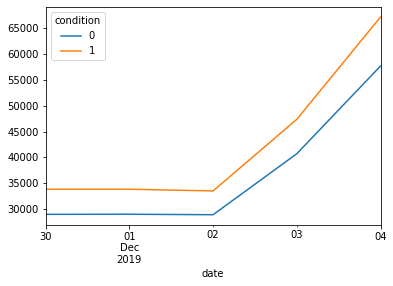

In [24]:
# plot the timeseries for each A/B group
temp.unstack().plot()

The experiment ran for five days. In the first three days, the number of users in both control group and the test group was relatively stable, and the number of users in the test group was slightly more than that in the experimental group. The number of users in both groups rose in the last two days.

In [25]:
# calculate the ratio of the test group and the control group each day
df.groupby('date')['conversion'].agg(ratio = lambda a: a[df.condition == 1].mean() / a[df.condition == 0].mean() )

,ratio
date,
2019-11-30,0.858002
2019-12-01,0.894586
2019-12-02,0.911110
2019-12-03,0.891067
2019-12-04,0.923195


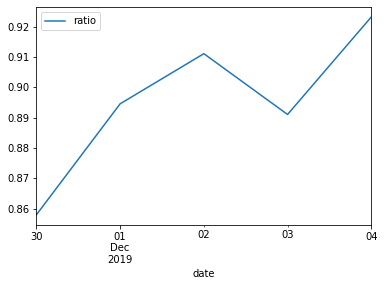

In [26]:
# plot the ratio
df.groupby('date')['conversion'].agg(ratio = lambda a: a[df.condition == 1].mean() / a[df.condition == 0].mean() ).plot()

- test group is consistently worse than control group over the 5 days.

- the experiment hasn't ran for 1-2 weeks to capture weekly pattern beacuse 12/03 - 12/04 have more traffic than first 3 days, probably due to weekly pattern. there is some limitation about this data.

4-2. By device

In [27]:
# count # of users by divice in each group
device_count = df.groupby('device')['condition'].agg(count_test = lambda a : len(a[a==1]), 
                                       count_control = lambda a : len(a[a==0]))
device_count

,count_test,count_control
device,,
GooglePixel,22141,19097
Huawei,29212,25374
Oppo,19353,16623
Sumsung,74090,63227
Xiaomi,2883,2494
iPad,19299,17078
iPhone,48742,41360


In [28]:
# calculate the percentage
device_count *100.0 / device_count.sum() #count the total # for each group

,count_test,count_control
device,,
GooglePixel,10.263768,10.308605
Huawei,13.541628,13.696944
Oppo,8.971352,8.973134
Sumsung,34.345448,34.130082
Xiaomi,1.336455,1.346267
iPad,8.946319,9.218744
iPhone,22.595031,22.326224


test and control are well balance(comparable) across device type, no bias in device.

# 5.Machine Learning to Automate Data Quality Check

- data filter and split

- one-hot enoding

- build a decision tree


- supervised learning: label - condition (being in test or control)


- features : other factors(excluding conversion)

**If there is a factor that can significantly explain which group a user is assigned to, it means that this factor may cause bias in the experiment**

Beacuse we have categorical and continous variables, we'll use decsion tree for a quick check & understanding.

In [29]:
# make a copy of df so it won't affect the orignal data
df_dt = df.copy()
df_dt.head()

,user_id,date,interface,language,channel,ads,device,conversion,condition,sex,state,age_group
0,435134,2019-11-30,app,English,SEO,NaN,iPhone,0,0,Female,Texas,< 30
1,310928,2019-12-04,browser,English,Ads,Baidu,Sumsung,0,0,Male,Massachusetts,< 30
2,836325,2019-11-30,app,English,Ads,Google,iPhone,0,0,Female,California,< 30
3,298244,2019-12-04,browser,English,Referral,NaN,Sumsung,0,0,Male,Michigan,30 - 50
4,614947,2019-12-04,app,English,Ads,Baidu,iPhone,0,1,Female,California,< 30


In [30]:
# drop columns we don't need
df_dt = df_dt.drop(['user_id', 'conversion', 'condition'], axis = 1)

In [31]:
# convert date to string so that the column can convert to dummy variable
df_dt['date'] = df_dt['date'].apply(str)

In [32]:
# set target variable
Y = df['condition']

In [33]:
df_dt = pd.get_dummies(df_dt)
df_dt.head()

,date_2019-11-30 00:00:00,date_2019-12-01 00:00:00,date_2019-12-02 00:00:00,date_2019-12-03 00:00:00,date_2019-12-04 00:00:00,interface_app,interface_browser,language_Chinese,language_English,language_Others,channel_Ads,channel_Referral,channel_SEO,ads_Baidu,ads_Bing,ads_Google,ads_Other,ads_Yahoo,device_GooglePixel,device_Huawei,device_Oppo,device_Sumsung,device_Xiaomi,device_iPad,device_iPhone,sex_Female,sex_Male,state_Airzona,state_California,state_Florida,state_Georgia,state_Illinois,state_Indiana,state_Massachusetts,state_Michigan,state_New Jersey,state_New York,state_North Carolina,state_Ohio,state_Tennessee,state_Texas,state_Virginia,state_Washington,age_group_30 - 50,age_group_< 30,age_group_> 50
0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [34]:
# define the decision tree model
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced') # class_weight can adjust group weight

In [35]:
# fit the model
dt.fit(df_dt,Y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [36]:
# export the decision tree in dot format
export_graphviz(dt,out_file='dt_plot.dot',feature_names=df_dt.columns, proportion=True)

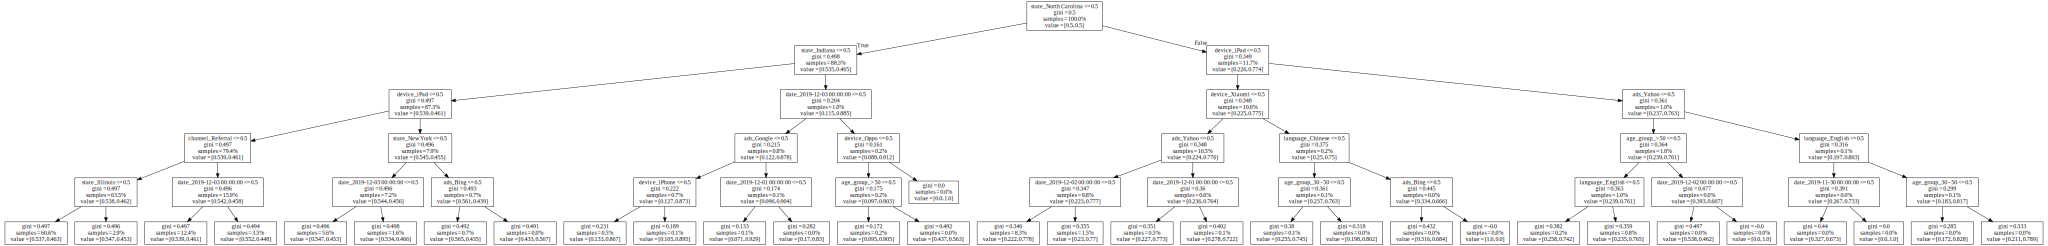

In [37]:
# plot the tree
graphviz.Source.from_file('dt_plot.dot')

In [38]:
df.loc[df.state=='North Carolina','condition'].mean()

0.7998630224942748

In [39]:
df.loc[df.state=='North Carolina','conversion'].mean()

0.013997388866297113

In [40]:
df.loc[df.state=='Indiana','condition'].mean()

0.8995400629387558

In [41]:
df.loc[df.state=='Indiana','conversion'].mean()

0.012829823287339627

North Carolina and Indiana are the two states with extremely low conversion rate and higher likelihood yo be in the test group. North Carolina has 79% users in the test and its average conversion rate is ~1%; Indiana has 89% users in test and its average conversion rate is ~1%.

Follow-ups:

- Investigate our experiment design and randomization logic, esp. allocation by state
- Remove PA, NC, IN from data and re-conduct t-test
- NC, IN: separate t-test
- t-test by each state

In [42]:
df2 = df.loc[~df.state.isin(['North Carolina', 'Indiana'])]
print(df2.state.unique())
df3 = df.loc[df.state.isin(['North Carolina', 'Indiana'])]
print(df3.state.unique())

['Texas' 'Massachusetts' 'California' 'Michigan' 'Florida' 'New Jersey'
 'Illinois' 'New York' 'Virginia' 'Airzona' 'Ohio' 'Tennessee' 'Georgia'
 'Washington']
['North Carolina' 'Indiana']


In [43]:
stats.ttest_ind(df2.loc[df2['condition']==1, 'conversion'], df2.loc[df2['condition']==0, 'conversion'], equal_var=False)

Ttest_indResult(statistic=0.36340782173835057, pvalue=0.7163004791299912)

In [44]:
stats.ttest_ind(df3.loc[df3['condition']==1, 'conversion'], df3.loc[df3['condition']==0, 'conversion'], equal_var=False)

Ttest_indResult(statistic=-0.956655241615398, pvalue=0.3387574569723738)

In [45]:
df.groupby('state')['conversion'].agg(conversion_rate_test = lambda a: a[df.condition==1].mean(),
                                      conversion_rate_control = lambda a: a[df.condition==0].mean(),
                                      sample_count_test = lambda a: a[df.condition==1].count(),
                                      sample_count_control = lambda a: a[df.condition==0].count(),
                                      p_value = lambda a: stats.ttest_ind(a[df.condition==1], a[df.condition==0], equal_var=False).pvalue)

,conversion_rate_test,conversion_rate_control,sample_count_test,sample_count_control,p_value
state,,,,,
Airzona,0.047551,0.050906,4206,4361,0.473003
California,0.051183,0.049498,64260,64184,0.167446
Florida,0.050590,0.052056,26962,27086,0.439732
Georgia,0.047918,0.049405,5572,5546,0.715656
Illinois,0.048995,0.049154,7858,8036,0.962964
Indiana,0.012917,0.012048,3716,415,0.878326
Massachusetts,0.047947,0.053567,4067,4107,0.247087
Michigan,0.050557,0.049929,16793,16864,0.792034
New Jersey,0.051305,0.048132,9882,9848,0.305148


# 6.Make Decisions

After we control the experiment result by state, the new UI vs. old UI are not statistically significantlly different from each other, with respect to conversion rate.

There are a couple of follow-uo investigation needed:
- The experiment is not well designed, withouout enough time window to collect weekly paatterns.
- There is something wrong with the randomization. We need to check the randomization code logic, and the data collection pipeline. Fine the SDE/DE/DS in charge of this.
-The current conclusion on NC and IN are still problematic, given its highly skewed data samples in test. We can 1) examine if the randomization is done right for the two states; 2) if yes, then we can try rebalance the data with adjustments or propensity score mathching, and re-do the t-test on balanced data for NC/IN.
- We don't have test data for PA, and PA is one of the key states in our customer base. We need to redo the experiment in a correct way for PA.
- Since the new UI and the old UI don't make any difference by state, we need to make the business decision based on other considerations, i.e. cost of replacement, code base maintenance, long-term consideration such acquistion, branding.